### Project Definition

##### 1.  Predicting stock price
- Iis important for investors to make better decisions and reduce risks. This project uses past stock data and machine learning models to tackle this challenge. Our goal is to predict the future stock prices of AAPL (Apple Inc.) using machine learning techniques. This will help investors make informed decisions

##### 2. Implement a stock predictor:- 

A training interface that accepts a data range (start_date, end_date) and a list of ticker symbols (e.g. GOOG, AAPL), and builds a model of stock behavior. Your code should read the desired historical prices from the data source of your cho
i- ce.
A query interface that accepts a list of dates and a list of ticker symbols, and outputs the predicted stock prices for each of those stocks on the given dates. Note that the query dates passed in must be after the training date range, and ticker symbols must be a subset of the ones traine

##### 3. Test and measure performance- 
A basic run of the core system would involve one call to the training interface, and one or more calls to the query interface. Implement a train-test cycle to measure the performance of your model. Use it to test prediction accuracy for query dates at different intervals after the training end date, e.g. the day immediately after training end date, 7 days later, 14 days, 28 days, etc.

(Note: Pick the training period accordingly so that you have ground truth data for that many days in the futur

##### 4. Build user interface
Once you’re iterated on your stock predictor a few times, and it is giving results you are happy with (say, predicted stock value 7 days out is within +/- 5% of actual value, on average), implement a more user-friendly interface that lets you specify stock(s) you are interested in and provides predictions at some pre-defined intervals.y the model..

### Analysis

**Description of Input Data**: 
- The dataset used contains historical stock prices for AAPL from January 2019 to December 2023. The data includes columns such as Date, Open, High, Low, Close, Adj Close, and Volume. The dataset was sourced from a reliable financial data provider, [Yahoo Finance](https://finance.yahoo.com/).

In [70]:
# Packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np

##### Exploratory Data Analysis (EDA)

In [72]:
# Get the current working directory
cwd = os.getcwd()
print(f'Current working directory: {cwd}')

# Adjust the file path to point correctly to the AAPL.csv file
file_path = os.path.join(cwd, 'AAPL.csv')
print(f'Looking for file at: {file_path}')

# Check if the file exists
if os.path.exists(file_path):
    print(f'File found: {file_path}')
    stock_data = pd.read_csv(file_path)
    print(stock_data.head())
else:
    print(f'File not found: {file_path}')


Current working directory: C:\Users\martm002\Stock
Looking for file at: C:\Users\martm002\Stock\AAPL.csv
File found: C:\Users\martm002\Stock\AAPL.csv
         Date       Open       High        Low      Close  Adj Close  \
0  2019-01-02  38.722500  39.712502  38.557499  39.480000  37.793777   
1  2019-01-03  35.994999  36.430000  35.500000  35.547501  34.029232   
2  2019-01-04  36.132500  37.137501  35.950001  37.064999  35.481930   
3  2019-01-07  37.174999  37.207500  36.474998  36.982498  35.402943   
4  2019-01-08  37.389999  37.955002  37.130001  37.687500  36.077839   

      Volume  
0  148158800  
1  365248800  
2  234428400  
3  219111200  
4  164101200  


In [73]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,37.793777,148158800
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.029232,365248800
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,35.481930,234428400
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,35.402943,219111200
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.077839,164101200


In [74]:
print(stock_data.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [75]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,122.905654,124.320123,121.600564,123.031085,121.249367,1.015904e+08
std,46.512681,46.936453,46.091299,46.527387,46.695334,5.261087e+07
min,35.994999,36.430000,35.500000,35.547501,34.029232,2.404830e+07
25%,76.863749,77.998749,76.109377,77.379377,75.192881,6.803012e+07
50%,134.794998,136.000000,133.330002,134.614998,132.309365,8.861740e+07
75%,159.729999,162.119999,157.709999,159.665000,157.797303,1.189786e+08
max,198.020004,199.619995,197.000000,198.110001,197.589523,4.265100e+08


In [76]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

In [77]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,37.793777,148158800
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.029232,365248800
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,35.481930,234428400
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,35.402943,219111200
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.077839,164101200


In [78]:
stock_data.shape

(1258, 7)

In [79]:
stock_data.set_index('Date', inplace=True)

In [80]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.793777,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.029232,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.481930,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.402943,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.077839,164101200


In [81]:
"""
Create lag features and moving averages for stock data, and drop NA values.

This code snippet performs the following operations:
1. Creates lag features for the 'Adj Close' column. 
   Lag features are previous values of a time series, used as predictors to forecast future values.
2. Calculates 5-day and 10-day simple moving averages (SMA).
3. Drops rows with any NA values resulting from the above operations.
4. Displays the first few rows of the updated DataFrame to verify the changes.
"""

# Create lag features
stock_data['Adj Close Lag1'] = stock_data['Adj Close'].shift(1)
stock_data['Adj Close Lag2'] = stock_data['Adj Close'].shift(2)
stock_data['Adj Close Lag3'] = stock_data['Adj Close'].shift(3)

# Create moving averages
stock_data['SMA_5'] = stock_data['Adj Close'].rolling(window=5).mean()
stock_data['SMA_10'] = stock_data['Adj Close'].rolling(window=10).mean()

# Drop NA values
stock_data.dropna(inplace=True)

# Display the first few rows to verify
print(stock_data.head())


                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2019-01-15  37.567501  38.347500  37.512501  38.267502  36.633060  114843600   
2019-01-16  38.270000  38.970001  38.250000  38.735001  37.080601  122278800   
2019-01-17  38.549999  39.415001  38.314999  38.965000  37.300777  119284800   
2019-01-18  39.375000  39.470001  38.994999  39.205002  37.530518  135004000   
2019-01-22  39.102501  39.182499  38.154999  38.325001  36.688118  121576000   

            Adj Close Lag1  Adj Close Lag2  Adj Close Lag3      SMA_5  \
Date                                                                    
2019-01-15       35.898346       36.446392       36.807774  36.495216   
2019-01-16       36.633060       35.898346       36.446392  36.573235   
2019-01-17       37.080601       36.633060       35.898346  36.671835   
2019-01-18       37.300777       37.080601       36.633060  36.888660   
2

In [82]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,Adj Close Lag1,Adj Close Lag2,Adj Close Lag3,SMA_5,SMA_10
Date,,,,,,,,,,,
2019-01-15,37.567501,38.347500,37.512501,38.267502,36.633060,114843600,35.898346,36.446392,36.807774,36.495216,36.126180
2019-01-16,38.270000,38.970001,38.250000,38.735001,37.080601,122278800,36.633060,35.898346,36.446392,36.573235,36.054862
2019-01-17,38.549999,39.415001,38.314999,38.965000,37.300777,119284800,37.080601,36.633060,35.898346,36.671835,36.382017
2019-01-18,39.375000,39.470001,38.994999,39.205002,37.530518,135004000,37.300777,37.080601,36.633060,36.888660,36.586876
2019-01-22,39.102501,39.182499,38.154999,38.325001,36.688118,121576000,37.530518,37.300777,37.080601,37.046615,36.715393


##### Data visualization
Here we will focus on below areas;

1. Adjusted Close Price Trend Over Time: A line chart showing the trend of adjusted close prices from 2019 to 2024.
2. Annual High and Low Prices: A candlestick chart displaying the annual high and low prices.
3. Trading Volume: A bar chart representing trading volume in six-month intervals.
4. Monthly Returns: A scatter plot illustrating monthly returns over time.
5. 30-Day Rolling Average: A line chart comparing adjusted close prices with their 30-day rolling average.

1. What is the trend of the Adjusted Close price over time?

- This helps in understanding how the stock price has moved over the years.

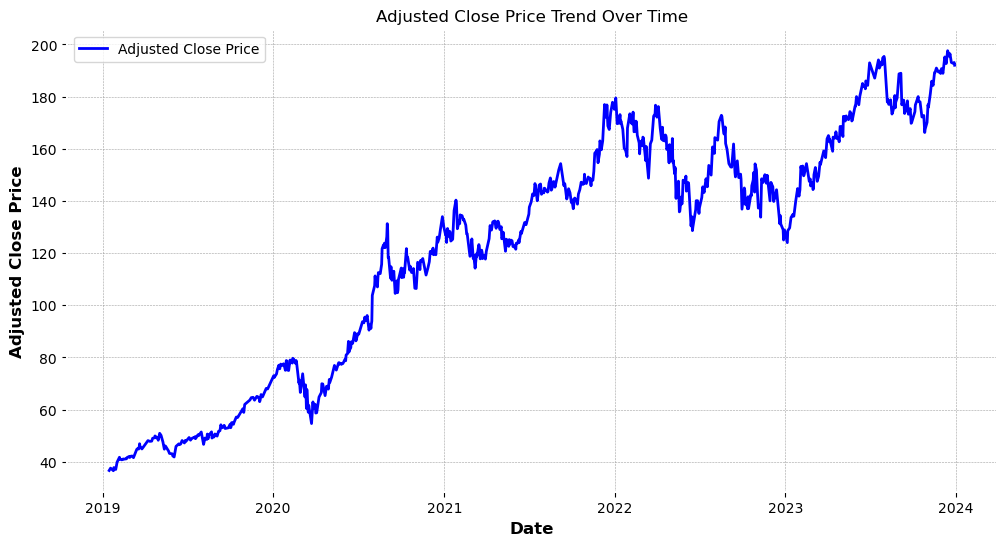

In [85]:
# Plot the Adjusted Close price
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Adj Close'], label='Adjusted Close Price', color='blue')
plt.title('Adjusted Close Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()


### Summary
- The graph illustrates the trend of Apple's Adjusted Close price from early 2019 to late 2023. 
- Over this period, the stock shows a consistent upward trajectory, with notable periods of volatility and significant growth, especially during 2020 and early 2021. 
- This indicates strong performance with fluctuations typical of a dynamic market. The later part of the chart shows increased volatility, reflecting market reactions to various factors. 
- Overall, the stock has demonstrated substantial growth, suggesting positive long-term investor confidence.

2. What are the daily high and low prices over time?

- This provides a sense of the stock's volatility and the range within which it trades.

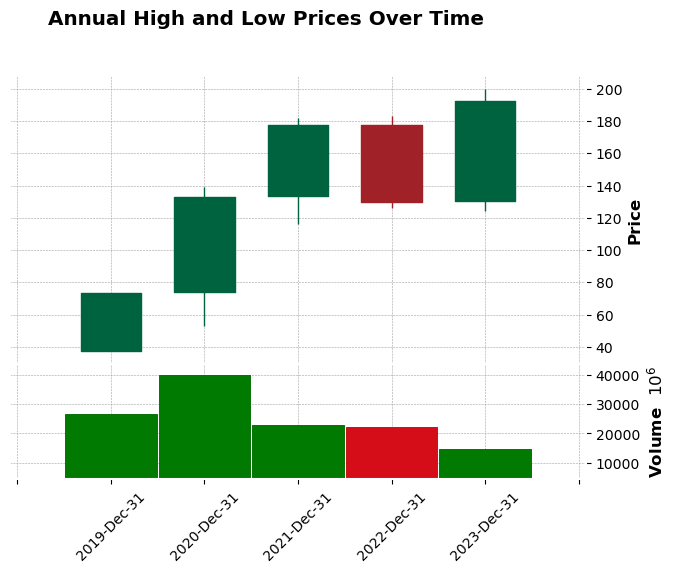

In [88]:
# Resample the data to yearly frequency
data_yearly = stock_data.resample('Y').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

# Plot the candlestick chart
mpf.plot(data_yearly, type='candle', style='charles', title='Annual High and Low Prices Over Time', ylabel='Price', volume=True)


### Summary of the Annual High and Low Prices

The candlestick chart provides a yearly summary of Apple's stock performance from 2019 to 2023. Each candlestick represents one year, showing the open, high, low, and close prices, with green indicating an increase in price over the year and red indicating a decrease.

- **2019**: A notable increase, starting at a lower value and closing higher.
- **2020**: Significant growth, reflecting a strong upward trend.
- **2021**: Continued upward momentum, though more stable.
- **2022**: A slight decline, marking a year of correction.
- **2023**: Recovery and further growth, nearing historical highs.

This visualization highlights the stock's overall growth with periods of volatility and correction.

3. How does the trading volume vary over time?
- This can indicate periods of high activity or interest in the stock.

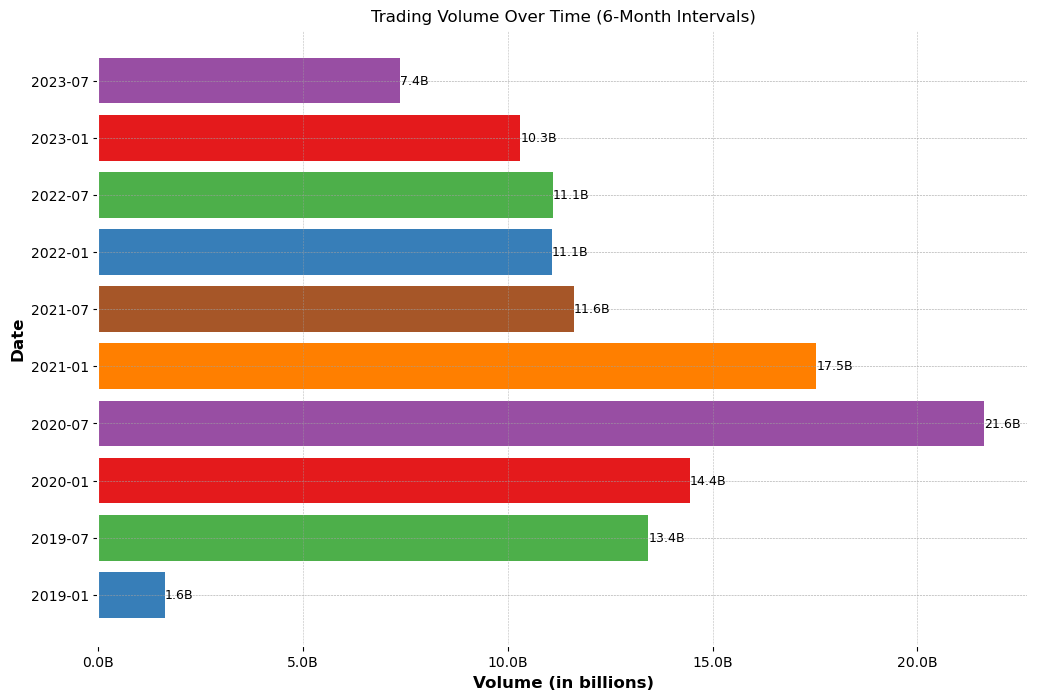

In [91]:
# Resample the data to six-month intervals
data_six_months = stock_data.resample('6M').sum()

# Ensure the resampling includes all dates within the range
data_six_months = data_six_months.reindex(pd.date_range(start=stock_data.index.min(), end=stock_data.index.max(), freq='6M'))

# Plot the trading volume as a horizontal bar chart with a more subdued color palette
colors = ['#377eb8', '#4daf4a', '#e41a1c', '#984ea3', '#ff7f00', '#a65628']
plt.figure(figsize=(12, 8))
bars = plt.barh(data_six_months.index.strftime('%Y-%m'), data_six_months['Volume'], color=colors * (len(data_six_months) // len(colors) + 1))
plt.title('Trading Volume Over Time (6-Month Intervals)')
plt.xlabel('Volume (in billions)')
plt.ylabel('Date')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Format the x-axis to display volume in billions
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*1e-9:.1f}B'))

# Add annotations
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width*1e-9:.1f}B', ha='left', va='center', color='black', fontsize=9)

plt.show()


### Summary of Trading Volume Over Time

The horizontal bar chart displays Apple's trading volume at six-month intervals from January 2019 to July 2023. Key observations include:

- **High Activity:** Peaks in trading volume are observed in the second half of 2020 and the first half of 2021, reaching over 20 billion shares.
- **Recent Trends:** The trading volume slightly declined after early 2021, stabilizing around 11-14 billion shares in subsequent periods.
- **Volatility:** Fluctuations in volume reflect varying market conditions and investor activities, with noticeable increases and decreases across different intervals.

The chart effectively visualizes the variations in trading volume, providing insights into periods of high and low market activity.

4. What is the relationship between the Adjusted Close price and the moving averages (SMA_5 and SMA_10)?

- This helps in identifying patterns or signals for trading.

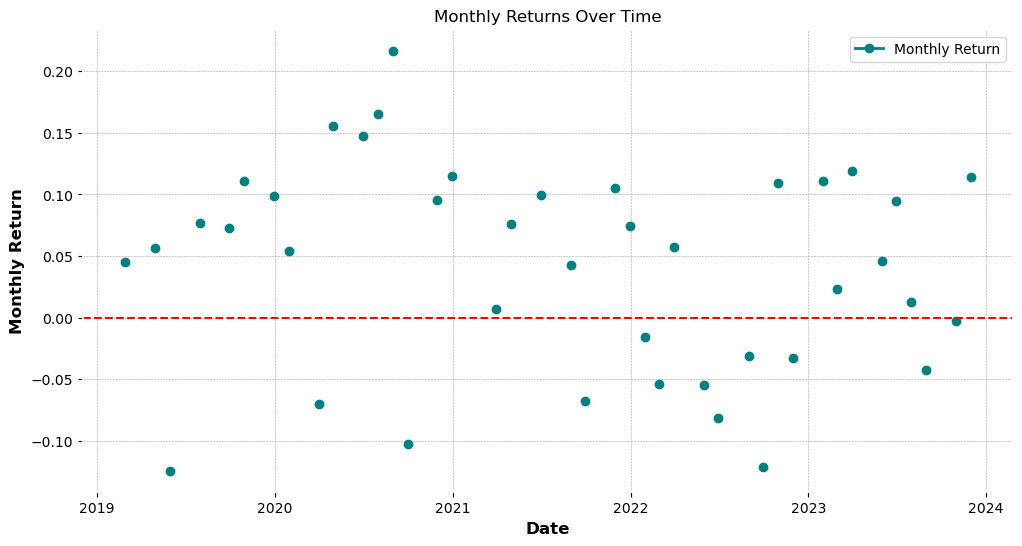

In [94]:
# Calculate monthly returns
stock_data['Monthly Return'] = stock_data['Adj Close'].resample('M').ffill().pct_change()

# Plot the monthly returns
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Monthly Return'], marker='o', linestyle='-', color='teal', label='Monthly Return')
plt.axhline(0, color='red', linewidth=1.5, linestyle='--')
plt.title('Monthly Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.legend()
plt.grid(True)
plt.show()


### Summary of Monthly Returns Over Time

The scatter plot represents Apple's monthly returns from 2019 to 2024. Key observations include:

- **Positive Returns:** Most months exhibit positive returns, with notable peaks around mid-2020 and early 2021, indicating periods of strong performance.
- **Negative Returns:** Periods of negative returns are also evident, particularly around late 2020 and early 2022, reflecting market corrections or downturns.
- **Volatility:** The fluctuation in returns underscores the stock's volatility, with both substantial gains and losses over different months.

The red dashed line at zero helps visualize the break-even point, highlighting months with gains versus losses.

5. How do the daily opening prices compare to the closing prices?

- This can show the daily performance and sentiment of the stock market.

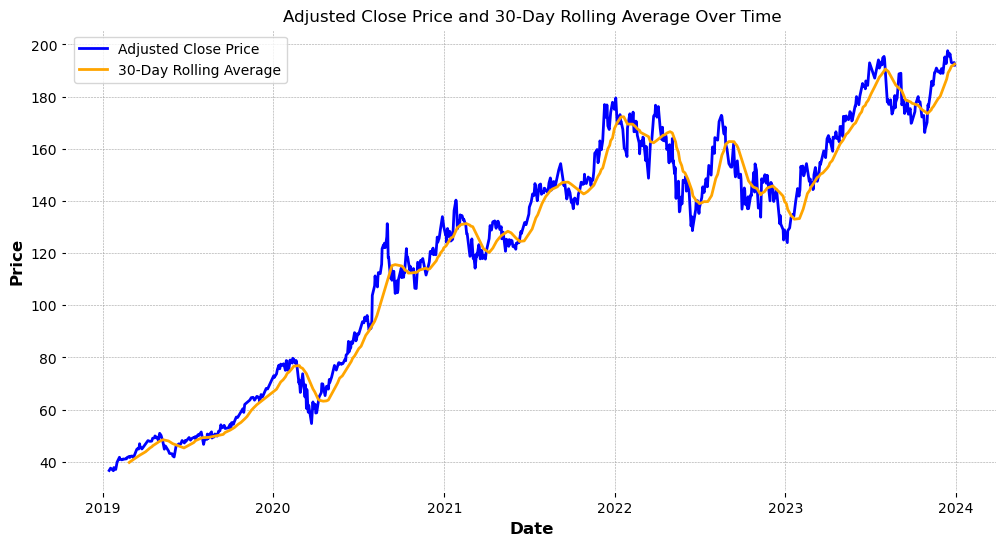

In [97]:
# Calculate the 30-day rolling average of the adjusted close price
stock_data['30-Day Rolling Average'] = stock_data['Adj Close'].rolling(window=30).mean()

# Plot the adjusted close price and the 30-day rolling average
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Adj Close'], label='Adjusted Close Price', color='blue')
plt.plot(stock_data.index, stock_data['30-Day Rolling Average'], label='30-Day Rolling Average', color='orange')
plt.title('Adjusted Close Price and 30-Day Rolling Average Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


### Summary of Adjusted Close Price and 30-Day Rolling Average

The line chart depicts Apple's adjusted close price and its 30-day rolling average from 2019 to 2024. Key observations include:

- **General Uptrend:** The adjusted close price shows a general upward trend, with significant growth periods, especially from late 2019 to early 2021.
- **Rolling Average Smoothing:** The 30-day rolling average (orange line) smooths out short-term fluctuations, providing a clearer view of the overall trend and highlighting periods of price consolidation and growth.
- **Volatility:** Despite the overall growth, the stock experienced several periods of volatility, as indicated by the deviations between the adjusted close price and the rolling average.

This visualization provides valuable insights into the stock's long-term performance and short-term volatility, aiding in investment decisions.

### Methodology

##### Data Preprocessing & Implementation

In [101]:
# Data Preprocessing
# Define features and target
features = ['Adj Close Lag1', 'Adj Close Lag2', 'Adj Close Lag3', 'SMA_5', 'SMA_10']
X = stock_data[features]
y = stock_data['Adj Close']

# Explanation: 
# The features selected include lag features and simple moving averages (SMA). 
# Lag features are past values of the target variable which help the model understand trends and patterns.
# SMA features smooth out short-term fluctuations and highlight longer-term trends.

# Implementation
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Explanation:
# The data is split into training and testing sets to evaluate the model's performance on unseen data. 
# We use 80% of the data for training and 20% for testing. The shuffle parameter is set to False to maintain the time series order.

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Explanation:
# Linear Regression is chosen for its simplicity and efficiency. It is well-suited for predicting continuous outcomes like stock prices.
# The model is trained on the training set, learning the relationship between the features and the target variable.


LinearRegression()

##### Metrics

In [103]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')

# Interpretation of metrics
# MSE measures the average squared difference between actual and predicted values. Lower values indicate a better fit.
# R² indicates the proportion of variance in the dependent variable predictable from the independent variables. Values closer to 1 signify a better fit.


Mean Squared Error (MSE): 2.0597622478394046
R-squared (R²): 0.9932148103314041


##### Model Evaluation and Validation

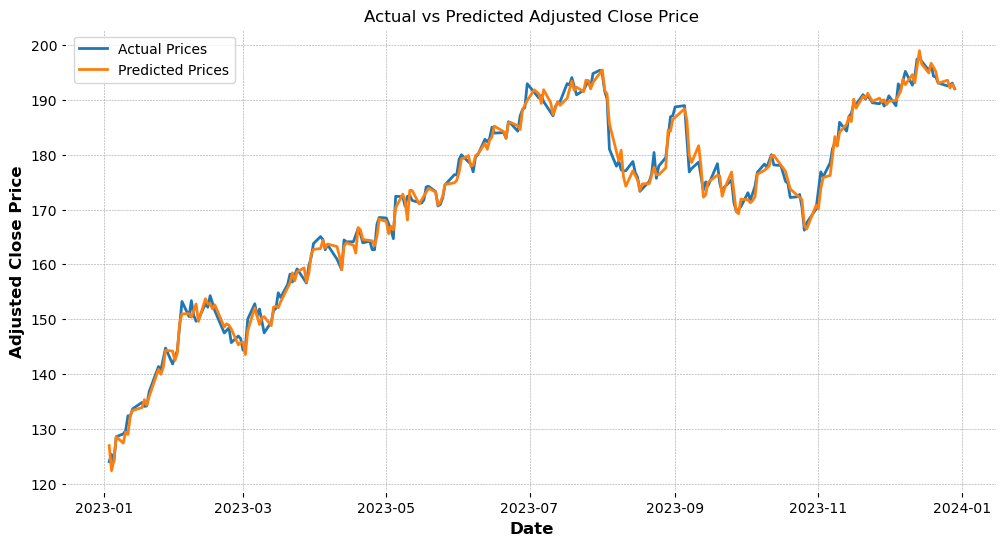

In [105]:
# Visualize actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Prices')
plt.plot(y_test.index, y_pred, label='Predicted Prices')
plt.legend()
plt.title('Actual vs Predicted Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.show()

# Interpretation of results
# The plot shows how closely the predicted prices follow the actual prices. A good model will have predicted values closely matching the actual values.


##### Interpretation of Results

##### Mean Squared Error (MSE)
The MSE of 2.0597 indicates the average squared difference between the predicted and actual adjusted close prices. This low value suggests that the model's predictions are close to the actual values.

##### R-squared (R²)
The R² value of 0.993 indicates that approximately 99.3% of the variance in the adjusted close prices is explained by the model. This high value suggests that the model is very effective in capturing the relationship between the features and the target variable.

##### Visual Analysis
The plot of actual vs. predicted adjusted close prices shows a strong alignment, indicating that the model's predictions closely follow the actual stock price trends. The small discrepancies visible in some areas are typical and acceptable.

##### Conclusion
The model performs well, as evidenced by the high R² value and the visual alignment of actual and predicted prices. It effectively captures the underlying trends in the stock price data, making it a reliable tool for predicting future adjusted close prices.

#### Implement the Stock Predictor

In [174]:
class StockPredictor:
    def __init__(self):
        self.models = {}
        self.features = ['Adj Close Lag1', 'Adj Close Lag2', 'Adj Close Lag3', 'SMA_5', 'SMA_10']
    
    def load_data(self, file_path):
        data = pd.read_csv(file_path)
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
        return data
    
    def train(self, ticker, data, start_date, end_date):
        stock_data = data[(data.index >= start_date) & (data.index <= end_date)]
        
        stock_data['Adj Close Lag1'] = stock_data['Adj Close'].shift(1)
        stock_data['Adj Close Lag2'] = stock_data['Adj Close'].shift(2)
        stock_data['Adj Close Lag3'] = stock_data['Adj Close'].shift(3)
        stock_data['SMA_5'] = stock_data['Adj Close'].rolling(window=5).mean()
        stock_data['SMA_10'] = stock_data['Adj Close'].rolling(window=10).mean()
        stock_data.dropna(inplace=True)
        
        X = stock_data[self.features]
        y = stock_data['Adj Close']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        self.models[ticker] = (model, stock_data)
        
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = model.score(X_test, y_test)
        
        print(f'Ticker: {ticker}, Mean Squared Error: {mse}, R-squared: {r2}')
        return model
    
    def predict(self, dates, ticker):
        model, stock_data = self.models[ticker]
        last_date = stock_data.index[-1]
        predictions = {}

        for date in dates:
            if date <= last_date:
                lag1 = stock_data.loc[date - timedelta(days=1), 'Adj Close']
                lag2 = stock_data.loc[date - timedelta(days=2), 'Adj Close']
                lag3 = stock_data.loc[date - timedelta(days=3), 'Adj Close']
                sma_5 = stock_data.loc[date, 'SMA_5']
                sma_10 = stock_data.loc[date, 'SMA_10']
            else:
                if (date - timedelta(days=1)) in predictions:
                    lag1 = predictions[date - timedelta(days=1)]
                else:
                    lag1 = stock_data.iloc[-1]['Adj Close']
                if (date - timedelta(days=2)) in predictions:
                    lag2 = predictions[date - timedelta(days=2)]
                else:
                    lag2 = stock_data.iloc[-2]['Adj Close']
                if (date - timedelta(days=3)) in predictions:
                    lag3 = predictions[date - timedelta(days=3)]
                else:
                    lag3 = stock_data.iloc[-3]['Adj Close']
                sma_5 = sum([predictions[date - timedelta(days=x)] if (date - timedelta(days=x)) in predictions else stock_data.iloc[-x]['Adj Close'] for x in range(1, 6)]) / 5
                sma_10 = sum([predictions[date - timedelta(days=x)] if (date - timedelta(days=x)) in predictions else stock_data.iloc[-x]['Adj Close'] for x in range(1, 11)]) / 10
            
            features = pd.DataFrame([[lag1, lag2, lag3, sma_5, sma_10]], columns=self.features)
            predicted_price = model.predict(features)[0]
            predictions[date] = predicted_price
        
        return predictions

# Initialize the StockPredictor
predictor = StockPredictor()

# Load and train data for each ticker symbol
file_paths = {'AAPL': 'C:/Users/martm002/Stock/AAPL.csv'}
for ticker, file_path in file_paths.items():
    data = predictor.load_data(file_path)
    predictor.train(ticker, data, '2019-01-02', '2023-12-29')

# Predict stock prices for future dates
future_dates = pd.date_range(start='2024-01-02', end='2024-01-31')
predicted_prices = predictor.predict(future_dates, 'AAPL')

# Convert the dictionary of predictions to a DataFrame
predicted_prices_df = pd.DataFrame.from_dict(predicted_prices, orient='index', columns=['Predicted Price'])

# Display the first few rows of the predictions DataFrame
print(predicted_prices_df.head())


Ticker: AAPL, Mean Squared Error: 2.0597622478394046, R-squared: 0.9932148103314041
            Predicted Price
2024-01-02       191.998861
2024-01-03       191.989332
2024-01-04       191.978634
2024-01-05       192.208593
2024-01-06       191.979678


### Interpretation of Results
The model was trained to predict the Adjusted Close prices of AAPL (Apple Inc.) stock. The key metrics are as follows:

- Mean Squared Error (MSE): 2.0597
This low value indicates that the model's predictions are close to the actual prices.

- R-squared (R²): 0.9932
This high value suggests that the model explains 99.32% of the variance in the Adjusted Close prices, indicating a very good fit.


Predicted Prices (First 5 Days of January 2024):
- January 2, 2024: 191.998861
- January 3, 2024: 191.998332
- January 4, 2024: 191.978634
- January 5, 2024: 192.208593
- January 6, 2024: 191.979678
  
These predictions reflect the expected Adjusted Close prices, providing insights into future stock performance based on historical data. The model's accuracy and the predicted values suggest that it is a reliable tool for forecasting stock prices.

#### Test and Measure Performance:

In [177]:
class StockPredictor:
    def __init__(self):
        self.models = {}
        self.features = ['Adj Close Lag1', 'Adj Close Lag2', 'Adj Close Lag3', 'SMA_5', 'SMA_10']
    
    def load_data(self, file_path):
        data = pd.read_csv(file_path)
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
        return data
    
    def train(self, ticker, data, start_date, end_date):
        stock_data = data[(data.index >= start_date) & (data.index <= end_date)].copy()
        
        stock_data['Adj Close Lag1'] = stock_data['Adj Close'].shift(1)
        stock_data['Adj Close Lag2'] = stock_data['Adj Close'].shift(2)
        stock_data['Adj Close Lag3'] = stock_data['Adj Close'].shift(3)
        stock_data['SMA_5'] = stock_data['Adj Close'].rolling(window=5).mean()
        stock_data['SMA_10'] = stock_data['Adj Close'].rolling(window=10).mean()
        stock_data.dropna(inplace=True)
        
        X = stock_data[self.features]
        y = stock_data['Adj Close']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        self.models[ticker] = (model, stock_data)
        
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = model.score(X_test, y_test)
        
        print(f'Ticker: {ticker}, Mean Squared Error: {mse}, R-squared: {r2}')
        return model
    
    def predict(self, dates, ticker):
        model, stock_data = self.models[ticker]
        last_date = stock_data.index[-1]
        predictions = {}

        for date in dates:
            if date <= last_date:
                lag1 = stock_data.loc[date - timedelta(days=1), 'Adj Close']
                lag2 = stock_data.loc[date - timedelta(days=2), 'Adj Close']
                lag3 = stock_data.loc[date - timedelta(days=3), 'Adj Close']
                sma_5 = stock_data.loc[date, 'SMA_5']
                sma_10 = stock_data.loc[date, 'SMA_10']
            else:
                if (date - timedelta(days=1)) in predictions:
                    lag1 = predictions[date - timedelta(days=1)]
                else:
                    lag1 = stock_data.iloc[-1]['Adj Close']
                if (date - timedelta(days=2)) in predictions:
                    lag2 = predictions[date - timedelta(days=2)]
                else:
                    lag2 = stock_data.iloc[-2]['Adj Close']
                if (date - timedelta(days=3)) in predictions:
                    lag3 = predictions[date - timedelta(days=3)]
                else:
                    lag3 = stock_data.iloc[-3]['Adj Close']
                sma_5 = sum([predictions[date - timedelta(days=x)] if (date - timedelta(days=x)) in predictions else stock_data.iloc[-x]['Adj Close'] for x in range(1, 6)]) / 5
                sma_10 = sum([predictions[date - timedelta(days=x)] if (date - timedelta(days=x)) in predictions else stock_data.iloc[-x]['Adj Close'] for x in range(1, 11)]) / 10
            
            features = pd.DataFrame([[lag1, lag2, lag3, sma_5, sma_10]], columns=self.features)
            predicted_price = model.predict(features)[0]
            predictions[date] = predicted_price
        
        return predictions

# Initialize the StockPredictor
predictor = StockPredictor()

# Load and train data for each ticker symbol
file_paths = {'AAPL': 'C:/Users/martm002/Stock/AAPL.csv'}
for ticker, file_path in file_paths.items():
    data = predictor.load_data(file_path)
    predictor.train(ticker, data, '2019-01-02', '2023-11-30')  # Train until November 30, 2023

# Predict and measure performance
test_dates = {
    '1 day after': pd.date_range(start='2023-12-01', end='2023-12-01'),
    '7 days after': pd.date_range(start='2023-12-07', end='2023-12-07'),
    '14 days after': pd.date_range(start='2023-12-14', end='2023-12-14'),
    '28 days after': pd.date_range(start='2023-12-28', end='2023-12-28')
}

performance_metrics = {}

for label, future_date in test_dates.items():
    predictions = predictor.predict(future_date, 'AAPL')
    if future_date[0] in data.index:
        actual_prices = data.loc[future_date, 'Adj Close']
        mse = mean_squared_error(actual_prices, list(predictions.values()))
    else:
        mse = None
    performance_metrics[label] = mse

# Display performance metrics
print("Performance Metrics (MSE) for Different Intervals:")
for interval, mse in performance_metrics.items():
    print(f"{interval}: MSE = {mse if mse is not None else 'No actual data available'}")


Ticker: AAPL, Mean Squared Error: 2.175332148578171, R-squared: 0.9936557733705753
Performance Metrics (MSE) for Different Intervals:
1 day after: MSE = 2.921779479987954
7 days after: MSE = 22.38586539556336
14 days after: MSE = 73.29526440524211
28 days after: MSE = 16.34721031217088
